In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm.notebook import tqdm
import IPython.display as ipd
import os
import time

from siren import get_siren_model
from gabor_mfn import get_gabor_mfn_model
from audio_utils import (
    AudioSignalDataset, 
    train_inr_model, 
    evaluate_audio_model,
    evaluate_and_visualize,
    play_audio
)

from dqnn_core import get_dqnn_model
from dqnn_utils import (
    AudioQuantumDataset,
    train_dqnn,
    evaluate_dqnn,
    evaluate_and_visualize as evaluate_dqnn_and_visualize,
    create_dqnn_trained_model
)

In [2]:
# import qutip
# print(f"Using QuTip version: {qutip.__version__}")

In [3]:
torch.manual_seed(1)
np.random.seed(1)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [4]:
#f = "original"
#f = "downsampled"
#f = "inaudible"

audio_paths = [
    f"data/{f}/clarinet_by_mozart.wav",
    f"data/{f}/flute_by_bach.wav", 
    f"data/{f}/piano_by_bach.wav"
]
output_paths = [
    "outputs_clarinet",
    "outputs_flute",
    "outputs_piano"
]

for path in output_paths:
    if not os.path.exists(path):
        os.makedirs(path)

test, sr = sf.read(audio_paths[2])
ipd.Audio(test, rate=sr)



Training SIREN model on piano_by_bach.wav
Audio loaded: 44100 samples, 5.00 seconds at 8820Hz
Original amplitude range: (-0.1114, 0.1177)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (44100 samples)
SIREN model parameters: 82,945
Starting training for 5000 epochs...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed. Final loss: 0.000084, Best loss: 0.000067
SIREN training completed in 11.17 seconds


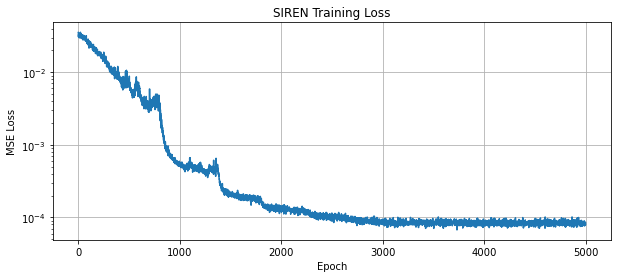


Evaluating SIREN model...
=== SIREN Evaluation (Denormalized)===
MSE: 0.000001
PSNR: 41.01 dB
Saved waveform plot to outputs_piano/siren_waveform.png



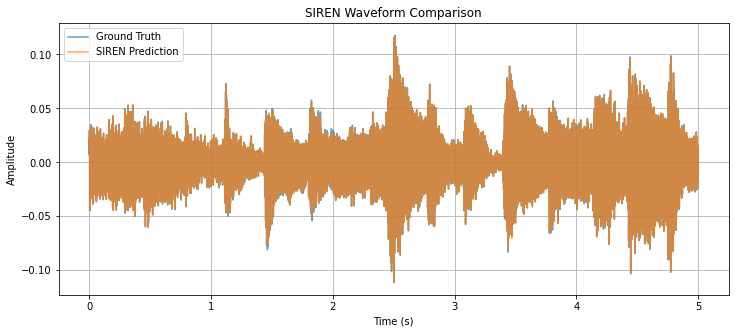

Ground Truth Audio (5.00 seconds):


SIREN Predicted Audio (5.00 seconds):


Saved predicted audio to outputs_piano/siren_audio.wav

Final SIREN metrics: MSE=0.000001, PSNR=41.01dB



In [37]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = output_paths[choice]

print("\n" + "="*50)
print(f"\nTraining SIREN model on {os.path.basename(audio_file)}")
print("="*50)

# Create dataset
dataset = AudioSignalDataset(
    audio_file,
    normalize_time=True,
    normalize_amplitude=True
)

# Configure SIREN model
hidden_size = 128
hidden_layers = 5                 # This means 5 + 1 = 6 Sinusoid activations
first_omega_0 = 3000

siren_model = get_siren_model(
    hidden_size=hidden_size,
    hidden_layers=hidden_layers,
    first_omega_0=first_omega_0
)

# Print model details
num_params = sum(p.numel() for p in siren_model.parameters())
print(f"SIREN model parameters: {num_params:,}")

# Training hyperparameters
num_epochs = 5000
batch_size = 2048
learning_rate = 1e-4

# Train SIREN model
start_time = time.time()

siren_model, siren_losses = train_inr_model(
    siren_model, 
    dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    lr=learning_rate, 
    device=device
)

training_time = time.time() - start_time
print(f"SIREN training completed in {training_time:.2f} seconds")

# Plot SIREN training curve
fig = plt.figure(figsize=(10, 4))
plt.plot(siren_losses)
plt.title("SIREN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.grid(True)
plt.show()
fig.savefig(f"{output_path}/siren_loss.png", dpi=300, bbox_inches='tight')

# Evaluate SIREN model
print("\nEvaluating SIREN model...")
predictions, ground_truth, mse, psnr = evaluate_and_visualize(
    siren_model, 
    dataset, 
    "SIREN",
    save_audio=f"{output_path}/siren_audio.wav",
    save_plot=f"{output_path}/siren_waveform.png"
)

print(f"\nFinal SIREN metrics: MSE={mse:.6f}, PSNR={psnr:.2f}dB\n")



Training Gabor MFN model on piano_by_bach.wav
Audio loaded: 44100 samples, 5.00 seconds at 8820Hz
Original amplitude range: (-0.1114, 0.1177)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (44100 samples)
Gabor MFN model parameters: 86,017
Starting training for 5000 epochs...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed. Final loss: 0.000001, Best loss: 0.000001
Gabor MFN training completed in 22.41 seconds


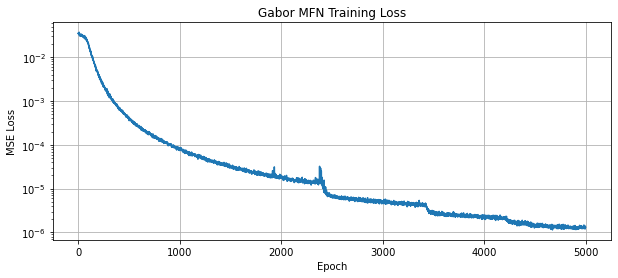

=== Gabor MFN Evaluation (Denormalized)===
MSE: 0.000000
PSNR: 59.13 dB
Saved waveform plot to outputs_piano/gabor_waveform.png



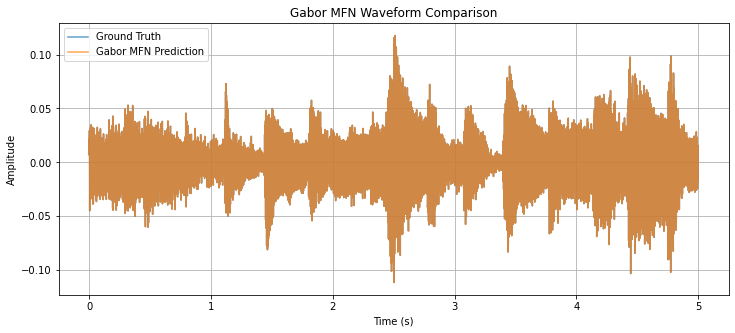

Ground Truth Audio (5.00 seconds):


Gabor MFN Predicted Audio (5.00 seconds):


Saved predicted audio to outputs_piano/gabor_audio.wav

Final Gabor MFN metrics: MSE=0.000000, PSNR=59.13dB



In [50]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = output_paths[choice]

print("\n" + "="*50)
print(f"\nTraining Gabor MFN model on {os.path.basename(audio_file)}")
print("="*50)

# Create dataset
dataset = AudioSignalDataset(
    audio_file,
    normalize_time=True,
    normalize_amplitude=True
)

# Configure Gabor MFN model
hidden_size = 128
num_layers = 7                # This means 7 - 2 = 5 Gabor filters
omega_0 = 3000

gabor_mfn_model = get_gabor_mfn_model(
    hidden_size=hidden_size,
    num_layers=num_layers,
    omega_0=omega_0
)

# Print model details
num_params = sum(p.numel() for p in gabor_mfn_model.parameters())
print(f"Gabor MFN model parameters: {num_params:,}")

# Training hyperparameters
num_epochs = 5000
batch_size = 2048
learning_rate = 1e-3

# Train Gabor MFN model
start_time = time.time()

gabor_mfn_model, gabor_mfn_losses = train_inr_model(
    gabor_mfn_model, 
    dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    lr=learning_rate, 
    device=device
)

training_time = time.time() - start_time
print(f"Gabor MFN training completed in {training_time:.2f} seconds")

# Plot Gabor MFN training curve
fig = plt.figure(figsize=(10, 4))
plt.plot(gabor_mfn_losses)
plt.title("Gabor MFN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.grid(True)
plt.show()
fig.savefig(f"{output_path}/gabor_loss.png", dpi=300, bbox_inches='tight')

# Evaluate Gabor MFN model
predictions, ground_truth, mse, psnr = evaluate_and_visualize(
    gabor_mfn_model, 
    dataset, 
    "Gabor MFN",
    save_audio=f"{output_path}/gabor_audio.wav",
    save_plot=f"{output_path}/gabor_waveform.png"
)

print(f"\nFinal Gabor MFN metrics: MSE={mse:.6f}, PSNR={psnr:.2f}dB\n")



Training DQNN model on piano_by_bach.wav
Audio loaded: 44100 samples, 5.00 seconds at 8820Hz
Original amplitude range: (-0.1114, 0.1177)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (44100 samples)
DQNN architecture: [1, 2, 3, 1]
DQNN model parameters: 474

Starting DQNN batched training for 50 epochs with 1 training rounds per batch...


Training:   0%|          | 0/50 [00:00<?, ?it/s]

DQNN Training completed in 501.80 seconds. Final quantum fidelity: 0.980002, Best: 0.980576


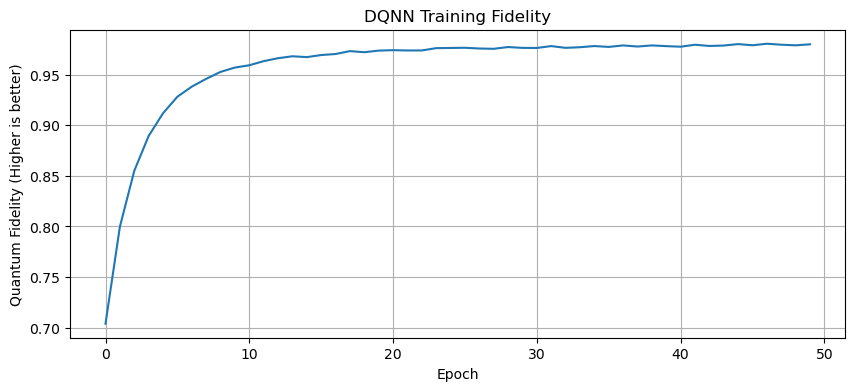


Evaluating DQNN model...


Evaluating DQNN:   0%|          | 0/22 [00:00<?, ?it/s]

=== DQNN Evaluation (Classical Domain) ===
Classical MSE: 0.000421
Classical PSNR: 15.17 dB
Note: Training used quantum fidelity but evaluation uses classical metrics
Saved waveform plot to outputs_piano/dqnn_waveform.png



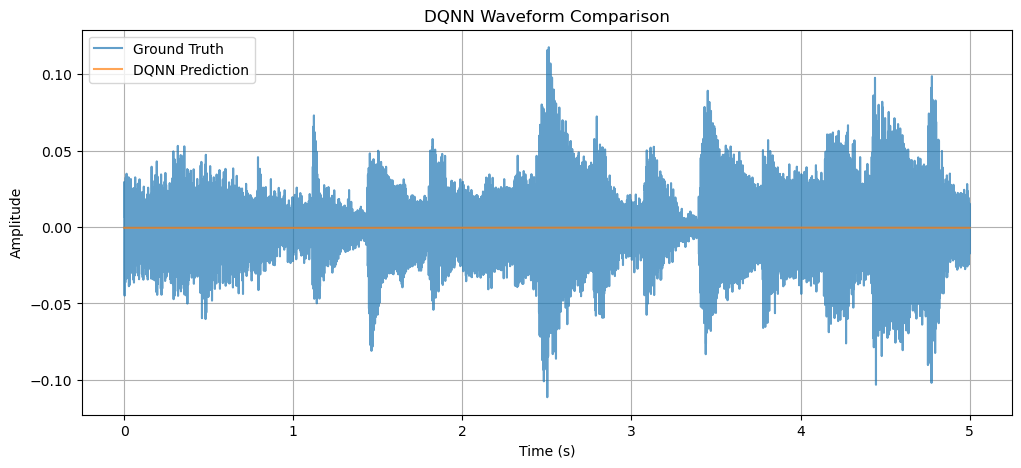

Ground Truth Audio (5.00 seconds):


DQNN Predicted Audio (5.00 seconds):


Saved predicted audio to outputs_piano/dqnn_audio.wav
DQNN final classical metrics: MSE=0.000421, PSNR=15.17dB


In [12]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = output_paths[choice]

print("\n" + "="*50)
print(f"\nTraining DQNN model on {os.path.basename(audio_file)}")
print("="*50)

# DQNN configuration - smaller for feasible simulation
qnn_arch = [1, 2, 3, 1]    # Input layer, hidden layers, output layer
lambda_param = 1            # Regularization parameter (related to inverse learning rate)
epsilon_param = 0.1          # Step size parameter
use_full_dataset = False         # True: Authors' original approach (training_rounds on full dataset)
                                 # False: Batched training approach (training_rounds per batch × num_epochs)

if use_full_dataset:
    training_rounds = 10    # Number of optimization rounds of the full dataset
    num_epochs = None       
    batch_size = None
else:
    num_epochs = 50         # Number of passes through dataset
    batch_size = 2048        # Samples seen per pass through dataset
    training_rounds = 1      # Rounds of optimization per sample in pass

# Train DQNN model with the chosen configuration
dqnn_model, dqnn_dataset, dqnn_results = create_dqnn_trained_model(
    audio_file,
    output_path=output_path,
    qnn_arch=qnn_arch,
    lda=lambda_param,
    ep=epsilon_param,
    num_epochs=num_epochs,
    batch_size=batch_size,
    training_rounds=training_rounds,
    use_full_dataset=use_full_dataset
)
# Extract results
dqnn_predictions, dqnn_ground_truth, dqnn_mse, dqnn_psnr = dqnn_results

print(f"DQNN final classical metrics: MSE={dqnn_mse:.6f}, PSNR={dqnn_psnr:.2f}dB")



Training DQNN model on piano_by_bach.wav
Audio loaded: 525 samples, 5.00 seconds at 105Hz
Original amplitude range: (-0.0034, 0.0036)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (525 samples)
DQNN architecture: [1, 3, 2, 1]
DQNN model parameters: 618

Verifying quantum encoding/decoding fidelity...
Processing 525 samples for both time and amplitude encoding/decoding...
Saved encoding verification plot to dqnn_state_analysis/quantum_encoding_verification.png



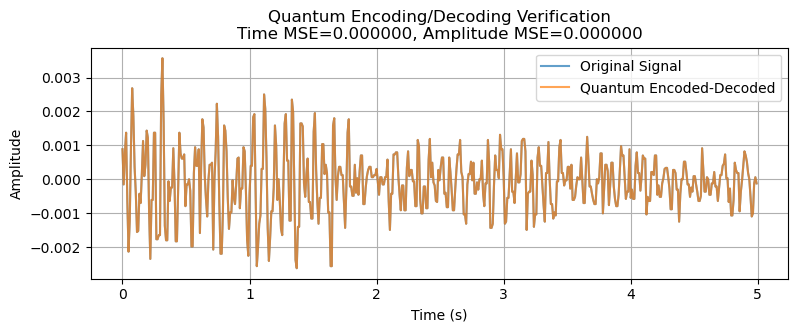

Encoding/decoding verification metrics:
Time MSE: 0.000000
Amplitude MSE: 0.000000

Starting DQNN full dataset training with 525 data points for 200 rounds...


Training:   0%|          | 0/200 [00:00<?, ?it/s]

DQNN full dataset training completed in 452.42 seconds.
Final quantum fidelity: 0.862015


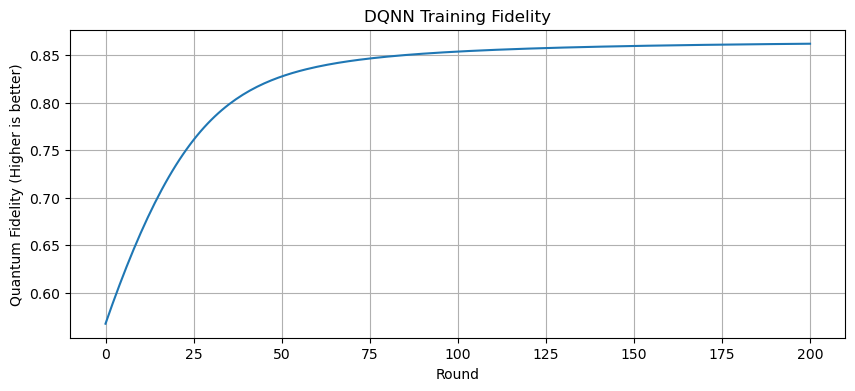


Evaluating DQNN model...


Evaluating DQNN:   0%|          | 0/525 [00:00<?, ?it/s]


=== DQNN Evaluation (Quantum Domain) ===
Average purity: 0.9893
Average Bloch vector length: 0.9892
Pure states (purity > 0.99): 27.62%
Average angle between target and output Bloch vectors: 35.10°
Average fidelity: 0.8620
Saved quantum state analysis plot to dqnn_state_analysis/dqnn_quantum_state_analysis.png


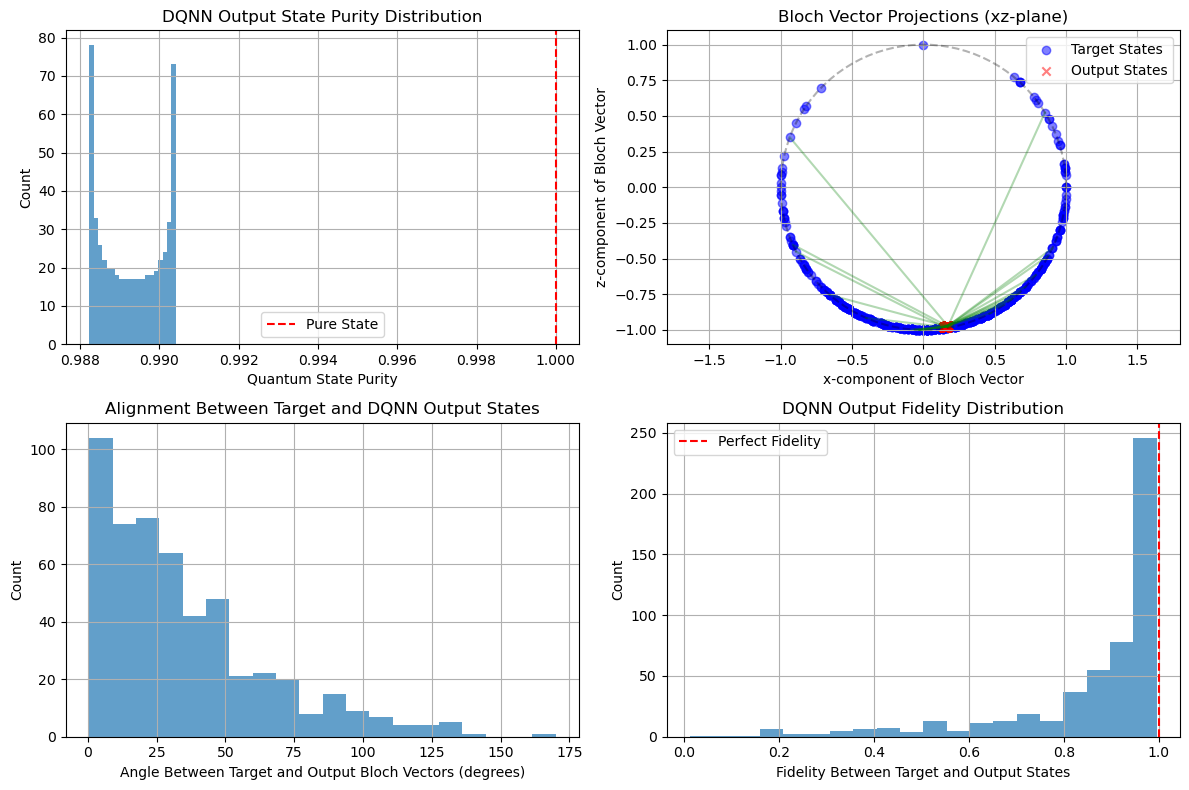


=== DQNN Evaluation (Classical Domain) ===
Classical MSE: 0.000001
Classical PSNR: 11.78 dB
Note: Training used quantum fidelity but evaluation uses classical metrics
Saved waveform plot to dqnn_state_analysis/dqnn_waveform.png



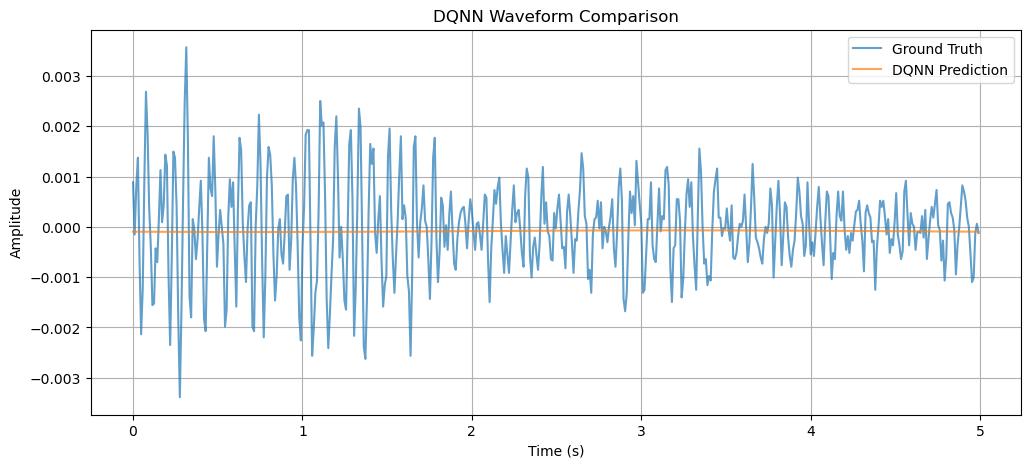

Ground Truth Audio (5.00 seconds):


DQNN Predicted Audio (5.00 seconds):


Saved predicted audio to dqnn_state_analysis/dqnn_audio.wav
DQNN final classical metrics: MSE=0.000001, PSNR=11.78dB


In [5]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = "dqnn_state_analysis"

print("\n" + "="*50)
print(f"\nTraining DQNN model on {os.path.basename(audio_file)}")
print("="*50)

# DQNN configuration - smaller for feasible simulation
qnn_arch = [1, 3, 2, 1]    # Input layer, hidden layers, output layer
lambda_param = 1            # Regularization parameter (related to inverse learning rate)
epsilon_param = 0.02          # Step size parameter
use_full_dataset = True         # True: Authors' original approach (training_rounds on full dataset)
                                 # False: Batched training approach (training_rounds per batch × num_epochs)

if use_full_dataset:
    training_rounds = 200    # Number of optimization rounds of the full dataset
    num_epochs = None       
    batch_size = None
else:
    num_epochs = 100         # Number of passes through dataset
    batch_size = 64          # Samples seen per pass through dataset
    training_rounds = 1      # Rounds of optimization per sample in pass

# Train DQNN model with the chosen configuration
dqnn_model, dqnn_dataset, dqnn_results = create_dqnn_trained_model(
    audio_file,
    output_path=output_path,
    qnn_arch=qnn_arch,
    lda=lambda_param,
    ep=epsilon_param,
    num_epochs=num_epochs,
    batch_size=batch_size,
    training_rounds=training_rounds,
    use_full_dataset=use_full_dataset,
    verify_encoding=True,
    analyze_quantum_states=True
)
# Extract results
dqnn_predictions, dqnn_ground_truth, dqnn_mse, dqnn_psnr = dqnn_results

print(f"DQNN final classical metrics: MSE={dqnn_mse:.6f}, PSNR={dqnn_psnr:.2f}dB")